# 0. create project structure and import utility functions
After doing this, put the required files in the "Input_files" folder. Including approximate names, these should be:
- Slide-tags spatial data   :   "df_whitelist_{Sample/Project/Run}.csv"
- 10x barcode pairs         :   "3M-february-2018.txt"                      or equivalent
- Known cell barcodes       :   "barcodes_{Sample}.csv"                     Single-cell derived barcodes
- Slide-tags results        :   "{Sample}_spatial.csv"                      Slide-tags results, used to analyse check results but not strictly required until then

It is also possible in each step to re-load config if changes are done in the middle.

In [1]:
from Utils import *
create_structure()
config = ConfigLoader('config_standard_processes.py') 

# 1. Process raw edge file

The edge file (df_whitelist_{Project}.txt) generated from Russell et als' pipeline has to through slight modification for easier handling in the downstream.

- The first cell loads packages and creates project structure if not already present, after running this the required files should be added to the "Input_files" folder. 

- The second step is mandatory, and entails switching the cell barcodes with their counterpart in the 10X provided barcode document denoted "3M-february-2018.txt".

- The third step is optional, and entails filtering the edge list, keeping only cells with a known position, as determined by Russell et al. This can also be used to remove any other barcodes you do not want to analyze. Both of these files are downloaded from the NCBI single-cell database for each specific experiment.

In [2]:
from initial_processing_functions import perform_preprocessing
perform_preprocessing(config)


Filtered whitelist reindexed
               cell_bc_10x         bead_bc  nUMI
0        AAACCCATCATCGCAA  AAAAATGTCCAGCC     1
1        AAACCCATCATCGCAA  AAACTAACACGTAC     1
2        AAACCCATCATCGCAA  AACCCGAAACGATT     1
3        AAACCCATCATCGCAA  AACCCGCGGGAGCT     1
4        AAACCCATCATCGCAA  AACCTGAACCCATA     1
...                   ...             ...   ...
1949179  TTTGTTGAGTAGGAAG  TTTCGTCCGCCGAT     1
1949180  TTTGTTGAGTAGGAAG  TTTGGGTGTGCGTG     1
1949181  TTTGTTGAGTAGGAAG  TTTGGTAATCTCGT     1
1949182  TTTGTTGAGTAGGAAG  TTTGTATGCATCGC     5
1949183  TTTGTTGAGTAGGAAG  TTTGTTGGACAAGT     1

[1949184 rows x 3 columns]


# 2. Filter edgelist
The main purpose is to remove certain beads with undesirable properties. The main usage is to remove beads which only connects to a single cell and beads with a "N" base, but can also be used to:
- Remove beads with more than a certain amount of total UMIs and/or neighbours. 
- Impose a lower limit for the number of UMIs per individual bead-cell edge. 
As standard, only the beads with only a single bead-cell connection and "N" in the sequence are removed, and the other options are not applied but can be changed in the config file. It uses the same config as the previous step.

In [3]:
from filtering_functions import perform_filtering

perform_filtering(config)

                     cell_bc_10x  nUMI
bead_bc                               
AAAAATGTCCAGCC  AAACCCATCATCGCAA     1
AAACTAACACGTAC  AAACCCATCATCGCAA     1
AACCCGAAACGATT  AAACCCATCATCGCAA     1
AACCCGCGGGAGCT  AAACCCATCATCGCAA     1
AACCTGAACCCATA  AAACCCATCATCGCAA     1
...                          ...   ...
TTTATCGACAATCC  TTTGTTGAGTAGGAAG     1
TTTCCGCATGGAGG  TTTGTTGAGTAGGAAG     2
TTTGGGTGTGCGTG  TTTGTTGAGTAGGAAG     1
TTTGGTAATCTCGT  TTTGTTGAGTAGGAAG     1
TTTGTATGCATCGC  TTTGTTGAGTAGGAAG     5

[1620741 rows x 2 columns]
                bead_bc       cell_bc_10x  nUMI
0        AAAAATGTCCAGCC  AAACCCATCATCGCAA     1
1        AAACTAACACGTAC  AAACCCATCATCGCAA     1
2        AACCCGAAACGATT  AAACCCATCATCGCAA     1
3        AACCCGCGGGAGCT  AAACCCATCATCGCAA     1
4        AACCTGAACCCATA  AAACCCATCATCGCAA     1
...                 ...               ...   ...
1620736  TTTATCGACAATCC  TTTGTTGAGTAGGAAG     1
1620737  TTTCCGCATGGAGG  TTTGTTGAGTAGGAAG     2
1620738  TTTGGGTGTGCGTG  TTTGTTGA

# 3. Generate subgraphs
Subgraphs are important since that is what is actually reconstructed. They are the immediate precursor to reconstruction, and there are several options for which subgraphs we generate and subsequently reconstruct.
- Network type - Filtering generates both the bipartite bead-cell network, but also unimodal projections with two separate weight metrics: UMI-sum and N beads per cell-cell connection
- Minumum subgraph size - using subgraphs below a certain size is not only uninformative but will also likely reconstruct poorly, it should always be at least 15, recommended is at least 100 
- Various filters - The numbers are lower filter boundaries, meaning it will only include edges with weight higher or equal to the specific number. They are in list form, and if a type of filter is empty that type of subgraphs will not be generated


In [4]:
from subgraph_processing_functions import perform_subgraph_generation_by_filtering
perform_subgraph_generation_by_filtering(config)

No Unipartite bead-weight matrix found
No Unipartite UMI-weight matrix found


# 4. Reconstruct
When reconstructing, it will use the subgraphs generated by the previous step and in the "Subgraph_reconstruction" deposit the reconstructed positions. This is the final "linear" processing step.It is possible to reconstruct several times, and its possible to chose which filtering thresholds and specific subgraphs are reconstructed. Standard is all for both. It is also possible to choose reconstruction dimension, with the standard being 2.


In [5]:
from reconstruction_functions import interpret_config_and_reconstruct
interpret_config_and_reconstruct(config)

['bi-umis_1']
['bi-umis_1']
['bi-umis_1']
['bi-umis_1']
input         Subgraph_edgelists/tonsil/run=all_cells_filters=numi2-1500_nconn2-1500_w1/bi-umis_1/subgraph_1_N=93859_unw.csv
info output   STRND_structure/tonsil/run=all_cells_filters=numi2-1500_nconn2-1500_w1/bi-umis_1
strnd input   STRND_structure/data/edge_lists
strnd recon   STRND_structure/data/reconstructed_positions
final output  Subgraph_reconstructions/tonsil/run=all_cells_filters=numi2-1500_nconn2-1500_w1/bi-umis_1_2D
Project structure created under 'c:\Users\simon.kolmodin\Desktop\Slide_Tag\github_publication_test/STRND_structure'
Title Edge List subgraph_1_N=93859_unw.csv
proximity_mode experimental
Unweighted graph
No duplicates found.
Edge list columns are valid.
Disconnected (or disordered) graph! Finding largest component...
Size of the total graph 389100
Size of largest connected component: 93859
Average Degree sparse: 34.41858532479571
running reconstruction...
reconstruction mode: STRND
ground truth available: F

  0%|          | 0/938590 [00:00<?, ?it/s]

reconstruction done!
                                                             Value  \
Property                                                             
num_points                                                   93859   
num_edges                                                  1615247   
average_degree                                           34.418585   
proximity_mode                                        experimental   
dimension                                                        2   
edge_list_title  edge_list_N=93859_dim=2_experimental_edge_list...   
bipartiteness                                                False   

                       Category  
Property                         
num_points       Graph Property  
num_edges        Graph Property  
average_degree   Graph Property  
proximity_mode        Parameter  
dimension             Parameter  
edge_list_title       Parameter  
bipartiteness    Graph Property  


# 5. Visualising reconstruction
Reconstructing is the final standard step. Further possible actions are for example:
NOTE: This uses a separate config file
- Enriching subgraphs to add edges from lower filters
- Gating subgraphs based on reconstructed distance
- Analyzing reconstructions
- Assessing general network qualities 

These options have separate config files, and some are based on files from different parts of this notebook. This means thats its not necessarily required to go through this entire notebook to run them, but its still recommended since many steps are based on the "basic" reconstructions or compare to it within the modules. As base, two reconstruction quality metrics are shown, K-Nearest Neighbours (KNN) and Correlated Pairwise Distances (CPD) are shown by default for local and global quality respectively. 

Visualization options that require no further major modifications include: distortion, morphed reconstruction, and morphed distortion, alla available through simply changing the relevant visualization option in the config.

To further analyze the reconstruction metrics more deeply, please go to the "additional_subgraph_analysis" notebook, or to modify the subgraphs using enrichment, distance gating, or dbscan clustering please use the "subgraph_modification" notebook


Initializing files

Current Threshold:  1
Initializing files
Reading edgelist
Generating Subgraph object
Creating ground truth positions dataframe
check: Output_files\tonsil\run=all_cells_filters=numi2-1500_nconn2-1500_w1\bi-umis_1_2D/full_reconstruction_summary_subgraph_1_N=93859.csv
       node_ID           node_bc          node_type  type_prediction_score  \
0            1  AAACCCATCATCGCAA           B_memory                   -1.0   
1            2  AAACCCATCCGATCGG  B_germinal_center                   -1.0   
2            3  AAACCCATCGGTTAGT            B_naive                   -1.0   
3            4  AAACCCAGTCATTGCA            B_naive                   -1.0   
4            5  AAACCCACAGAAGTGC  B_germinal_center                   -1.0   
...        ...               ...                ...                    ...   
93854   387969    CATCGGCAATACTT               bead                   -1.0   
93855   387995    TTAAAGCCATGTCC               bead                   -1.0   
93856   3885

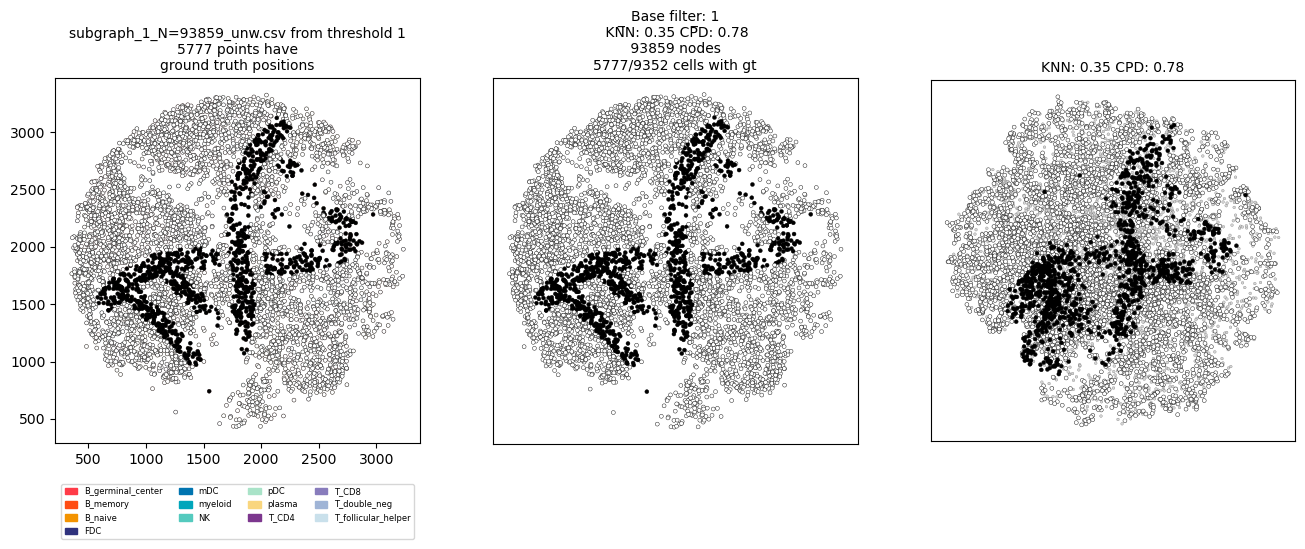

In [2]:
from Utils import *
from subgraph_analysis_functions import perform_analysis_actions
config_analysis = ConfigLoader('config_subgraph_analysis.py') 
# Comment the line below if its desired to run the analysis on another sample
config_analysis.base_network_args.unfiltered_edge_file = config.preprocessing_args.filepaths.output_file 

perform_analysis_actions(config_analysis)

This plot layout is such that to the left is the points in the subgraph with a ground truth overlayed on all ground truth points in light gray. To the right of this are the reconstructions, with the first row always being the ground truth positions for the that speicfic subgraph verions. The title of the column is the base filuter used, the mean KNN and CPD for all reconstrcutions fi there are multiple, how many total nodes in the subgraph including beads, and finally how many of those nodes are cells, and of those how many have a ground truth. The first column to the right of this will always be the base subgraph, without modifications. If there are multiple reconstructions shown (default is 1 reconstruction only) they wil be visible as rows under the ground truth, and if there are modified version of the subgraph, those will be new columns. the best reconstruction from a global perspective will have a blue outline, as well of the modification with the overall best global reconstruction quality